In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Using pr_nhome_compas
We adjust the probability of nursing home to be smaller or equal to the probablity of probability of survival to 85 years old.

In [2]:
df = pd.read_excel("..\data\compas_enquete_mll.xlsx")
df.rename(columns={'pr_nhome_compas': 'alpha1',
                   'pr_alive_85_compas': 'pi'},
          inplace=True)

print(f'prob dependency before 85: {(df.alpha1 > df.pi).mean()}')
df['alpha1'] = df[['alpha1', 'pi']].min(axis='columns')
df['alpha2'] = df.pi - df.alpha1
df['death'] = 1 - df.alpha1 - df.alpha2
df = df[['alpha1', 'alpha2', 'death']]
df.describe()

prob dependency before 85: 0.002


,alpha1,alpha2,death
count,2000.000000,2000.000000,2000.000000
mean,0.262085,0.385839,0.352076
std,0.112263,0.159902,0.119342
min,0.055000,0.000000,0.125000
25%,0.167500,0.267500,0.260000
50%,0.255000,0.332500,0.340000
75%,0.350000,0.562500,0.425625
max,0.522500,0.697500,0.937500


## Functions used below

In [3]:
def utility(x, eps=0.8):
    return x**(1 - eps) / (1 - eps)
        
def calc_UP_A1_A2(w, L1, L2, P, beta=0.8):
    UP = beta * (utility(w) - utility(w - P))
    A1 = utility(w - P) - utility(w - L1) + UP
    A2 = utility(w - P) - utility(w - L2) + UP
    return UP, A1, A2

def participation(w, L1, L2, P, df):
    UP, A1, A2 = calc_UP_A1_A2(w, L1, L2, P)
    return df.alpha1 * A1 + df.alpha2 * A2 - UP > 0

def average_cost(w, L1, L2, P, df):
    insured = participation(w, L1, L2, P, df)
    N = sum(insured * (df.alpha1 * L1 + df.alpha2 * L2))
    D = sum(insured)
    return N / (D + 1e-16)

def intersection(w, L1, L2, P, df):
    UP, A1, A2 = calc_UP_A1_A2(w, L1, L2, P)
    C = average_cost(w, L1, L2, P, df)
    alpha1_star = (C * A2 - UP * L2) / (A2 * L1 - A1 * L2)
    alpha2_star = UP/A2 - A1/A2 * alpha1_star
    return alpha1_star, alpha2_star

def prob_distr():
    plt.scatter(df.alpha1, df.alpha2, alpha=0.2, color='darkolivegreen')
    plt.xlim([0, 0.6])
    plt.ylim([0, 0.8])
#     plt.title('Probability distribution', fontsize=14)
    plt.xlabel(r'$\alpha_1$', fontsize=12)
    plt.ylabel(r'$\alpha_2$', fontsize=12)
    plt.grid()
    plt.savefig(f'figures/prob_distr.png', dpi=300)
    plt.show()

def create_final_figure(w, L1, L2, P, case):
    alpha1_star, alpha2_star = intersection(w, L1, L2, P, df)
    print(f'intersection at {round(alpha1_star, 3), round(alpha2_star, 3)}')

    UP, A1, A2 = calc_UP_A1_A2(w, L1, L2, P)
    C = average_cost(w, L1, L2, P, df)

    alpha1pref = [alpha1 for alpha1 in np.linspace(0, UP/A1, 100)]
    alpha2pref = [UP/A2 - alpha1 * A1/A2 for alpha1 in alpha1pref]

    alpha1cost = [alpha1 for alpha1 in np.linspace(0, C/L1, 100)]
    alpha2cost = [C/L2 - alpha1 * L1/L2 for alpha1 in alpha1cost]

    insured = participation(w, L1, L2, P, df)

    plt.scatter(df.alpha1[insured], df.alpha2[insured], alpha=0.2,
                color='darkolivegreen')
    plt.scatter(df.alpha1[~insured], df.alpha2[~insured], alpha=0.2,
                color='lightsalmon')
    plt.plot(alpha1pref, alpha2pref, label='isopreference', color='blue')
    plt.plot(alpha1cost, alpha2cost, label='isocost', color='black', linestyle='--')
    plt.xlim([0, 0.6])
    plt.ylim([0, 1.2])
#     plt.title('Propitious selection', fontsize=14)
    plt.xlabel(r'$\alpha_1$', fontsize=12)
    plt.ylabel(r'$\alpha_2$', fontsize=12)
    plt.grid()
    plt.legend()
    plt.savefig(f'figures/case_{case}.png', dpi=300)
    plt.show()

## Probability distribution

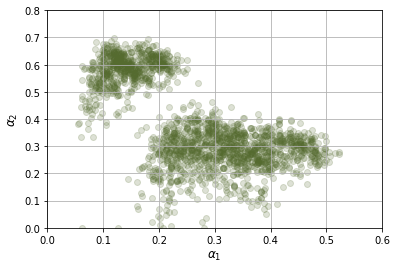

In [4]:
prob_distr()

## Case 1: L1=87000, L2=55000, P=57850

intersection at (0.183, 0.618)


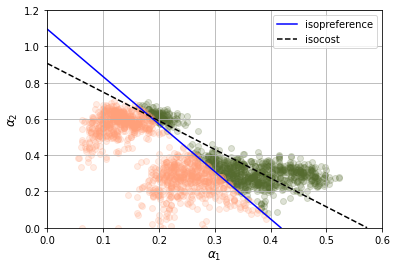

In [5]:
create_final_figure(w=100e3, L1=87e3, L2=55e3, P=57850, case=1)

## Case 2: L1=93000, L2=62000, P=63900

intersection at (0.166, 0.613)


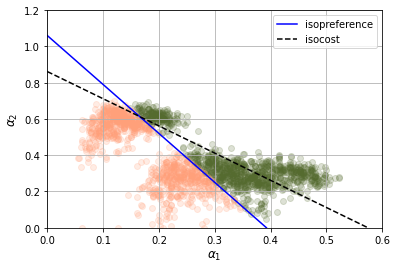

In [6]:
create_final_figure(w=100e3, L1=93e3, L2=62e3, P=63900, case=2)

## Case 3: L1=63000, L2=41000, P=51850

intersection at (0.479, 0.35)


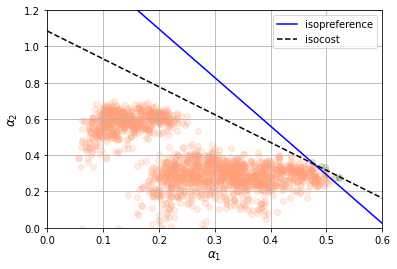

In [7]:
create_final_figure(w=72e3, L1=63e3, L2=41e3, P=51850, case=3)

## Case 4: L1=72000, L2=62000, P=62000

intersection at (0.119, 0.572)


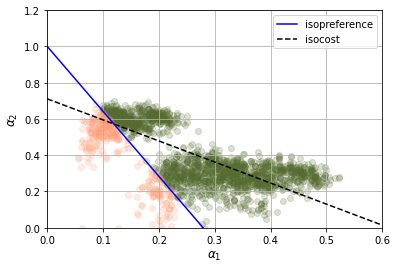

In [8]:
create_final_figure(w=72e3, L1=72e3, L2=62e3, P=62000, case=4)